In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport graph
%aimport hyper
%aimport vlgp

In [59]:
import os.path as op
import numpy as np
import scipy as sp
from scipy.special import expit
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth, svd
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis
import h5py
import pickle

import simulation, util, graph, hyper, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [4]:
# Setup graphics
sns.set(font_scale=1.5)
sns.set_style("white")
samplepath = op.expanduser("~/data/sample")
outputpath = op.expanduser("~/data/output")
figurepath = op.expanduser("~/data/figure")

In [12]:
# Graf_5 = loadmat(op.join(samplepath, 'Graf_5.mat'), squeeze_me=True)
Graf_5 = h5py.File(op.join(samplepath, 'Graf_5.mat'), 'r')

In [25]:
Graf_5['ori'].shape, Graf_5['y'].shape

((3600, 1), (148, 2560, 3600))

In [26]:
ori = np.squeeze(np.array(Graf_5['ori']))
unique_ori = np.unique(ori)
y = np.array(Graf_5['y'])
# transpose y (into trial, time, neuron)
y = np.transpose(y, axes=(2, 1, 0))

In [33]:
# extract trials orienting at 0 and 90 deg
y0 = y[ori == 0, :, :]
y90 = y[ori == 90, :, :]

In [43]:
# combine trials of 0 and 90 deg
y4fit = np.concatenate((y0, y90), axis=0)

In [48]:
# load previous hyperparameter
vLGP_4D = loadmat(op.join(outputpath, 'Graf_vLGP_4D.mat'), squeeze_me=True)['Graf_vLGP_4D']
omega = vLGP_4D['omega'].tolist()
print(omega)

[ 0.00016897  0.00021241  0.000177    0.00013326]


In [ ]:
nlatent = 4 # 4D latent
np.random.seed(0)
sigma = np.full(nlatent, fill_value=1.0)
fit = vlgp.fit(y4fit, ['spike'] * y4fit.shape[-1], sigma, omega, lag=2, rank=100, 
               niter=50, tol=1e-5, verbose=True, nadjhess=100, 
               nhyper=3, learn_sigma=False, learn_omega=False, adjhess=True)
savemat(op.join(outputpath, 'Graf_5_0_90_vLGP_4D_2'), fit)

In [52]:
fit_0_90_4D = fit

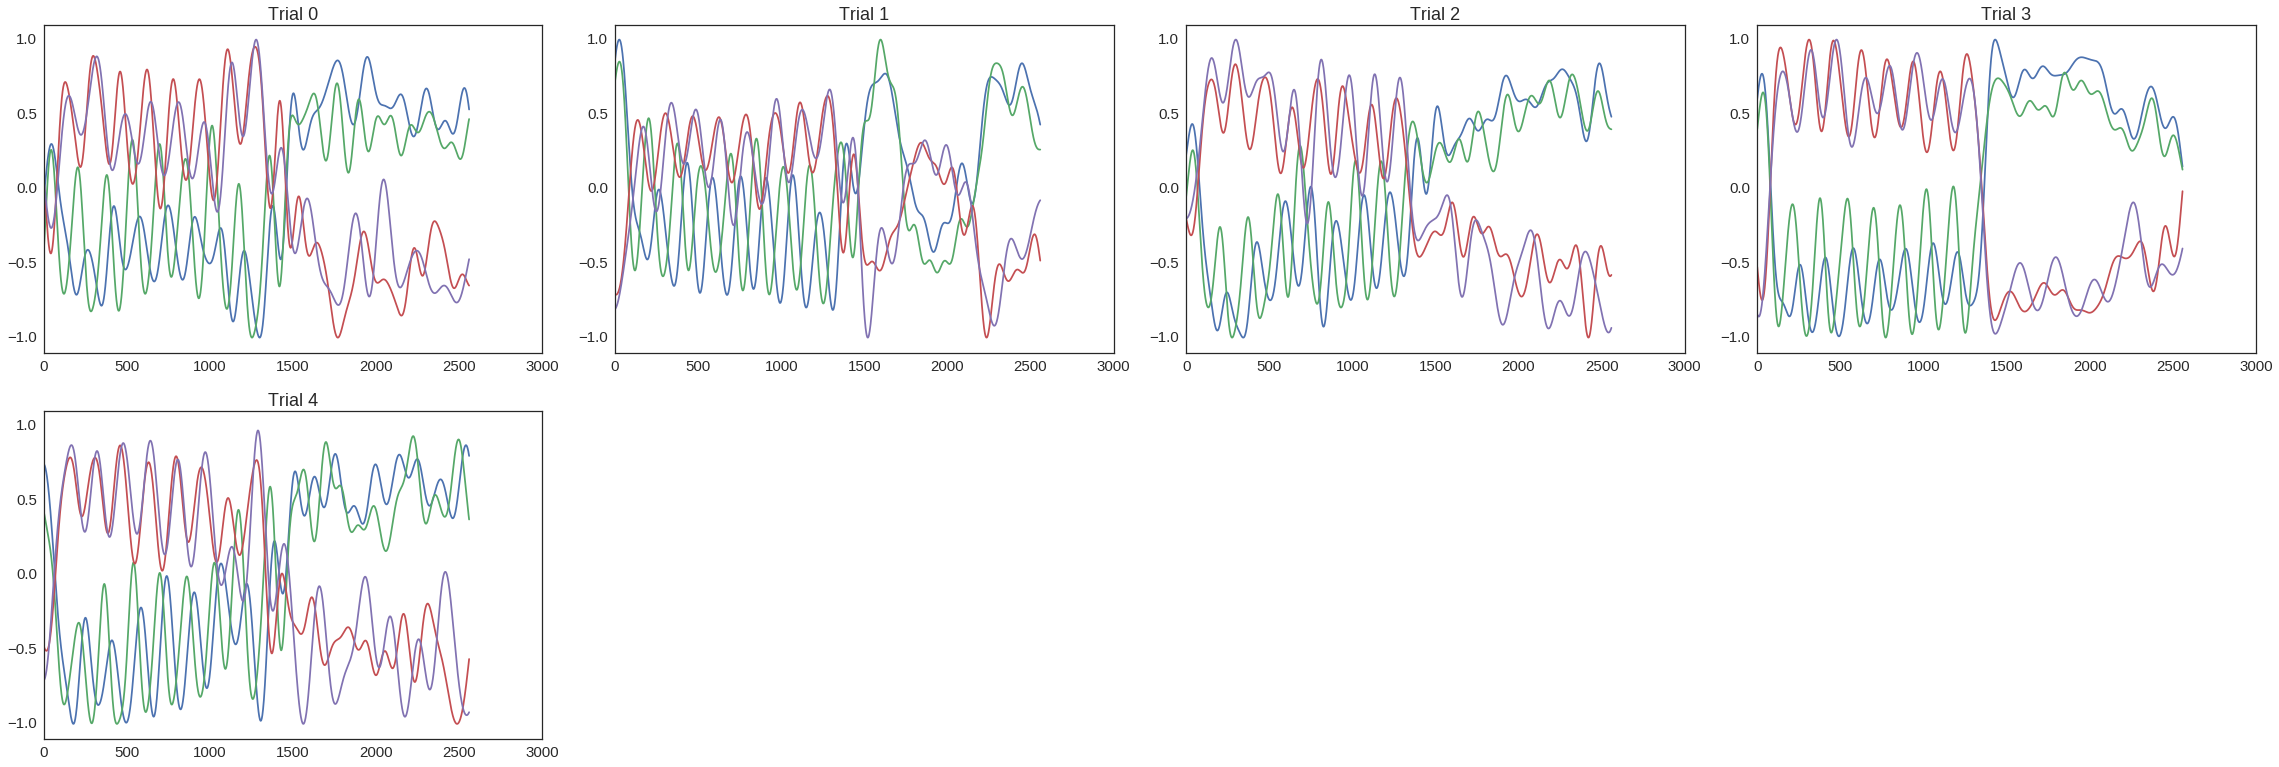

In [53]:
graph.dynplot(fit_0_90_4D['mu'][:5,:,:])

In [65]:
np.random.seed(0)
fit_all_4D = vlgp.fitpost(y, ['spike'] * y.shape[-1], sigma, omega, a=fit_0_90_4D['a'], b=fit_0_90_4D['b'], 
                          lag=2, rank=100, 
                          niter=50, tol=1e-5, verbose=True, nadjhess=100, 
                          nhyper=3, learn_sigma=False, learn_omega=False, moreparam=False)


Inference starts


MemoryError: 

In [64]:
# initialized at all zeros
np.random.seed(0)
fit_all_4D_0 = vlgp.fitpost(y, ['spike'] * y.shape[-1], sigma, omega, a=fit_0_90_4D['a'], b=fit_0_90_4D['b'],
                          mu0=np.zeros((y.shape[0], y.shape[1], nlatent), dtype=float),
                          lag=2, rank=100, 
                          niter=50, tol=1e-5, verbose=True, nadjhess=100, 
                          nhyper=3, learn_sigma=False, learn_omega=False, moreparam=False)


Inference starts


KeyboardInterrupt: 

In [62]:
with open(op.join(outputpath, 'Graf_5_all_vLGP_4D.dat'), 'wb') as outfile:
    pickle.dump(fit_all_4D, outfile, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# average the latent over trials
lat_avg = fit_0_90_4D['mu'].mean(axis=0)

In [ ]:
np.finfo(float).min